## Molecular dynamics of a nanoparticle
---
The goal of this exercise is to calculate limit of thermal stability of a layered Fe-Pt nanoparticle in high temperature. The following animation shows the kalorymetric function ($E_P - E_K$) of the nanoparticle together with fragments of animated MD trajectory at the indicated temperature. 

<video height=450 preload="metadata" type="video/webm" autoplay controls
    src="http://wolf.ifj.edu.pl/~jochym/p/notebooks/anim_e.webm" >
</video>

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from ase import Atoms
from ase.cluster import Cluster, Icosahedron
from ase import units as un
import ase.io
from IPython.core.display import Image
import numpy as np
from numpy import array, sum, std, mean
import scipy.interpolate as inter
from glob import glob
from tqdm.auto import tqdm

## Building of nanoparticle

First we need to build the ikosahedral nanoparticle of 55 atoms with layered structure (1Pt+12Fe+42Pt). The ASE library contains the `Icosahedron` function which we will use.

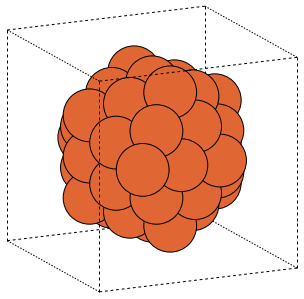

In [ ]:
ico=Icosahedron("Fe", 3); ico.center(vacuum=2.0)
ase.io.write('fe-ico.png', ico, show_unit_cell=2, rotation='115y,15x')
Image(filename='fe-ico.png')

### Layered structure

To obtain a layered structure we will use the same function to identify each layer and define its contents: alternating Fe and Pt atoms.

In [ ]:
def LC_ico(a1,a2,ln):
    '''
    Create layered icosahedral structure of order ln
    with alternating a1 and a2 atoms. 
    The surface layer contains atoms a1.
    '''
    ico=Icosahedron(a1,ln)
    icon=ico.get_atomic_numbers()
    for l in range(ln,0,-1):
        if (ln-l)%2 :
            a=a1
        else :
            a=a2
        il=Icosahedron(a,l)
        an=il.get_atomic_numbers()
        icon[:len(an)]=an
    ico.set_atomic_numbers(icon)
    return ico      

Here we will test our function by selecting and drawing one half of the particle using logical array to select visible atoms (by python's *fancy indexing* construct).

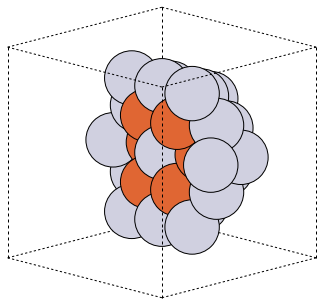

In [ ]:
lc=LC_ico("Fe","Pt",3); lc.center(vacuum=2.0)  # Nanoparticle
cut=lc.get_center_of_mass()[2]                 # Cut plane through CM
ase.io.write('onion.png',
             lc[[a.index for a in lc if a.position[2]>=cut]], # Select one side of xy plane
             show_unit_cell=2, rotation='135y,15x')
Image(filename='onion.png')

## Ab initio calculations

The DFT calculations used to create data included in the `data` directory took multiple months to perform. It is impossible to make such calculations inside the tutorial. Thus we need to skip the step of performing actual MD runs for several temperatures and read the resulting trajectories. The provided data is a small subset of results from a research-quality computation performed by the authors using VASP.

In [ ]:
md = {}
dt = 10.0 # fs
print('T= ', end='')
for fn in glob('data/md_T_*.traj'):
    T = int(fn.split('_')[-1][:-5])
    print(f'{T}', end=' ')
    md[T] = (dt, ase.io.Trajectory(fn))
print('K')

T= 1400 950 1100 700 1000 1450 1700 1300 2000 1500 1200 1600 900 150 1425 800 1350 600 500 300 850 K


## Trajectory analysis

To identify the melting point of the Pt-terminated nanoparticle we will calculate the kalorymetric function $E_p(T) - E_k(T)$ using:

* Potential energy calculated by DFT and stored together with the trajectory.
* Kinetic energy from the velocities calculated from the atomic positions:

$$
E_k(t_i)=\sum_{n=1}^{N_{at}}\frac{m_n {\mathbf v_n}(t_{i})^2}{2}=\sum_{n=1}^{N_{at}}\frac{m_n ({\mathbf x_n}(t_{i+1})-{\mathbf x_n}(t_{i}))^2}{2}
$$

### Trajectory processing

Following simple functions calculate velocities, kinetic energies and instantaneous temperatures based on the trajectory data.instantaneous

In [ ]:
def calc_velocities(a1,a2,dt):
    '''
    Calculate atomic velocities from positions a1, a2 
    and timestep dt.
    '''
    dx=(a2.get_positions()-a1.get_positions())
    c=Atoms(a2)
    tv=sum(c.get_cell(),axis=0)/2
    c.set_positions(dx)
    c.translate(tv)
    c.set_scaled_positions(c.get_scaled_positions())
    c.translate(-tv)
    return c.get_positions()/dt

def calc_kinen(tr,dt):
    '''
    Calculate kinetic energy history for trajectory tr 
    and timestep dt.
    '''
    m=tr[0].get_masses()
    Ek=[m*sum(calc_velocities(a1,a2,dt)**2,axis=1)/2 
                    for a1,a2 in zip(tr[:-1],tr[1:])]
    return Ek
    
def calc_temp(tr,dt):
    '''
    Calculate instantaneous temperature history for trajectory tr 
    and timestep dt.
    '''
    eka=calc_kinen(tr,dt)
    ek=sum(eka,axis=-1)
    ekd=std(eka,axis=-1)
    n=len(tr[0].get_masses())
    c=n/(n-1)
    return 2*c*ek/(3*n*un.kB), 2*c*ekd/(3*un.kB)

### Kinetic energy fluctuations

The DFT calculations have been performed in the NVT regime with a Nose thermostat, let us check if the expected temperature fluctuations agree with the assumed temperatures of the simulated system.

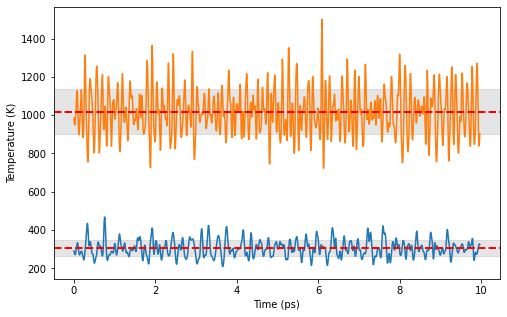

In [ ]:
plt.figure(figsize=(8,5))
for T in [300, 1000]:
    dt,tr=md[T]; temp,_=calc_temp(tr,dt*un.fs)
    avgT=mean(temp) ; devT=std(temp)
    plt.plot(dt*np.arange(len(temp))/1000,temp,'-')
    plt.axhline(avgT,ls='--',color='r',lw=2)
    plt.axhspan(avgT-devT,avgT+devT,color='C7',alpha=0.2)
plt.xlabel('Time (ps)'); plt.ylabel('Temperature (K)');

### Kalorymetric curve

Calculate:
 * Potential energy (from *ab-initio* data)
 * Kinetic energy 
 * Temperature

In [ ]:
dat=[]
for T in tqdm(sorted(md)):
    dt,tr=md[T]
    epot=array([s.get_potential_energy() for s in tr])
    epot=((epot[:-1]+epot[1:])/2)
    ekin=sum(array(calc_kinen(tr,dt*un.fs)),axis=-1)
    etot=epot+sum(ekin,axis=-1)
    temp_v, temp_d=calc_temp(tr,dt*un.fs)
    atemp=mean(temp_v)
    dat.append([atemp, mean(epot), mean(ekin),
                mean((etot-mean(etot))**2)/(un.kB*(atemp**2))])
dat=array(dat).T

  0%|          | 0/21 [00:00<?, ?it/s]

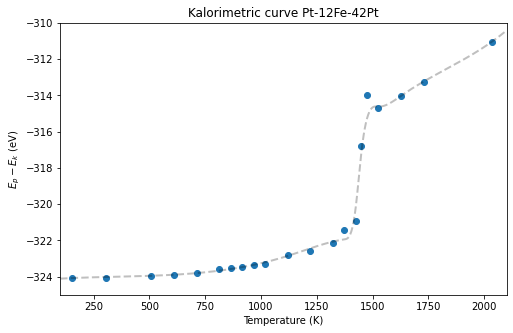

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(dat[0],dat[1]-dat[2],'o')
x=(dat[0])[np.arange(dat.shape[1])!=16]; 
y=(dat[1]-dat[2])[np.arange(dat.shape[1])!=16]
s=inter.UnivariateSpline(x, y, s=1.3)
xx=np.arange(100,2100,5)
plt.plot(xx,s(xx),'k--',lw=2,alpha=0.25);
plt.xlabel('Temperature (K)'); plt.ylabel('$E_p - E_k$ (eV)');
plt.title('Kalorimetric curve Pt-12Fe-42Pt')
plt.xlim(100,2100); plt.ylim(-325,-310); 